Creating a ML Project to take in cpu gpu and memory data and predict spikes before they happen


data file is already made along with script to collect the data 
1. clean data
2. split data
3. train lstm model 
4. let it predict


In [28]:
import pandas as pd 
import torch
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv("PcPerformanceData.csv")
features = ['cpu_usage_percent', 
            'gpu_usage_percent', 
            'memory_percent', 
            'disk_read', 
            'disk_write', 
            'past_cpu', 
            'past_gpu', 
            'past_memory']
target = ['future_cpu', 'future_gpu', 'future_memory']

X = df[features].values
y = df[target].values
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32) # making the data into tensors when using pytorch helps pergformance
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

In [ ]:
def create_sequences(X, y, seq_len=5): # creats sequences for lstm input
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

seq_len = 5
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)

In [ ]:
import torch.nn as nn

class SystemPredictor(nn.Module): # lstm model to predict cpu gpu and memory usage
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SystemPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        # take the last timestep
        out = self.fc(out[:, -1, :])
        return out

input_size = X_seq.shape[2]  # number of features
hidden_size = 64
output_size = y_seq.shape[1]  # number of labels (3)
num_layers = 1

model = SystemPredictor(input_size, hidden_size, output_size, num_layers)


In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #optimizer for training the model

num_epochs = 50
batch_size = 32


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_seq, y_seq)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs): # training loop
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [5/50], Loss: 0.0035
Epoch [10/50], Loss: 0.0037
Epoch [15/50], Loss: 0.0114
Epoch [20/50], Loss: 0.0224
Epoch [25/50], Loss: 0.0043
Epoch [30/50], Loss: 0.0067
Epoch [35/50], Loss: 0.0074
Epoch [40/50], Loss: 0.0037
Epoch [45/50], Loss: 0.0034
Epoch [50/50], Loss: 0.0032


In [ ]:

model.eval()

X_input = X_scaled[-seq_len:]  # take the last 5 rows
X_input_tensor = torch.tensor(X_input, dtype=torch.float32).unsqueeze(0)  # shape: (1, seq_len, features)

# Predict
with torch.no_grad():
    y_pred_scaled = model(X_input_tensor)

# Inverse transform to get original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.numpy())


Predicted future CPU, GPU, Memory: [[15.50815  11.101747 94.289566]]


In [44]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False  # don't shuffle for time-series
)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [45]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            val_outputs = model(batch_X)
            val_loss += criterion(val_outputs, batch_y).item()
    val_loss /= len(test_loader)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")


Epoch [5/50], Validation Loss: 0.0083
Epoch [10/50], Validation Loss: 0.0089
Epoch [15/50], Validation Loss: 0.0099
Epoch [20/50], Validation Loss: 0.0083
Epoch [25/50], Validation Loss: 0.0073
Epoch [30/50], Validation Loss: 0.0073
Epoch [35/50], Validation Loss: 0.0080
Epoch [40/50], Validation Loss: 0.0073
Epoch [45/50], Validation Loss: 0.0073
Epoch [50/50], Validation Loss: 0.0072


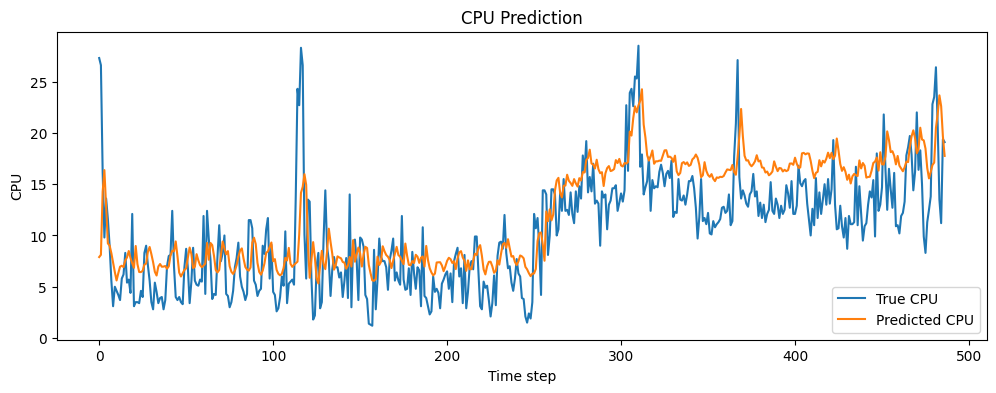

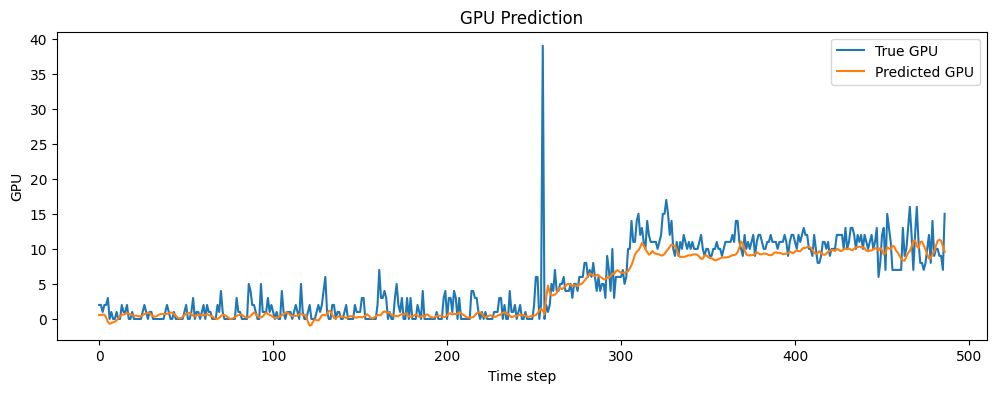

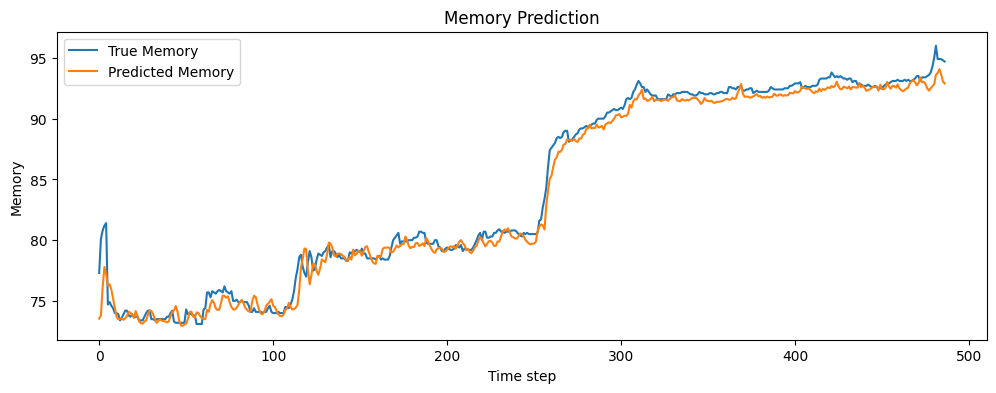

In [52]:
import matplotlib.pyplot as plt

# Make predictions on the full dataset
with torch.no_grad():
    y_pred_scaled = model(X_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.numpy())  # scale back to original

# True values
y_true = scaler_y.inverse_transform(y_seq.numpy())

# Plot CPU, GPU, Memory
labels = ['CPU', 'GPU', 'Memory']
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.plot(y_true[:, i], label=f'True {labels[i]}')
    plt.plot(y_pred[:, i], label=f'Predicted {labels[i]}')
    plt.title(f'{labels[i]} Prediction')
    plt.xlabel('Time step')
    plt.ylabel(labels[i])
    plt.legend()
    plt.show()

In [ ]:
# uses model to predict in real time pc performance
import psutil
import torch
import time
import numpy as np
import torch.nn as nn
import torch.optim as optim
import keyboard  # pip install keyboard

model.eval()
seq_len = 5
seq_buffer = []

online_lr = 0.0005
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=online_lr)

def get_gpu_usage():
    import subprocess
    try:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=utilization.gpu", "--format=csv,nounits,noheader"],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
        )
        return float(result.stdout.strip())
    except:
        return 0.0

print("Press 'q' at any time to quit.")

while True:
    if keyboard.is_pressed('q'):
        print("Exiting program...")
        break

    cpu = psutil.cpu_percent()
    mem = psutil.virtual_memory().percent
    gpu = get_gpu_usage()
    disk_io = psutil.disk_io_counters()
    disk_read = disk_io.read_count
    disk_write = disk_io.write_count

    if len(seq_buffer) == 0:
        past_cpu = cpu
        past_gpu = gpu
        past_mem = mem
    else:
        past_cpu = seq_buffer[-1][0]
        past_gpu = seq_buffer[-1][1]
        past_mem = seq_buffer[-1][2]

    row = [cpu, gpu, mem, disk_read, disk_write, past_cpu, past_gpu, past_mem]
    row_scaled = scaler_X.transform([row])

    seq_buffer.append(row_scaled[0])
    if len(seq_buffer) > seq_len:
        seq_buffer.pop(0)

    if len(seq_buffer) == seq_len:
        input_seq = torch.tensor([seq_buffer], dtype=torch.float32)
        target = torch.tensor([scaler_y.transform([[cpu, gpu, mem]])[0]], dtype=torch.float32)

        with torch.no_grad():
            pred_scaled = model(input_seq)
            pred = scaler_y.inverse_transform(pred_scaled.numpy())[0]

        cpu_error = pred[0] - cpu
        gpu_error = pred[1] - gpu
        mem_error = pred[2] - mem

        print(f"Predicted CPU: {pred[0]:.1f}%, Actual CPU: {cpu:.1f}%, Error: {cpu_error:.1f}")
        print(f"Predicted GPU: {pred[1]:.1f}%, Actual GPU: {gpu:.1f}%, Error: {gpu_error:.1f}")
        print(f"Predicted Mem: {pred[2]:.1f}%, Actual Mem: {mem:.1f}%, Error: {mem_error:.1f}")
        print("-"*40)

        # --- Online training ---
        model.train()
        optimizer.zero_grad()
        output = model(input_seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        model.eval()

    time.sleep(0.5)


Press 'q' at any time to quit.
Predicted CPU: 32.1%, Actual CPU: 31.6%, Error: 0.5
Predicted GPU: 14.0%, Actual GPU: 19.0%, Error: -5.0
Predicted Mem: 88.5%, Actual Mem: 90.5%, Error: -2.0
----------------------------------------
Predicted CPU: 31.9%, Actual CPU: 40.4%, Error: -8.5
Predicted GPU: 14.3%, Actual GPU: 19.0%, Error: -4.7
Predicted Mem: 88.7%, Actual Mem: 90.5%, Error: -1.8
----------------------------------------
Predicted CPU: 32.0%, Actual CPU: 37.3%, Error: -5.3
Predicted GPU: 14.6%, Actual GPU: 19.0%, Error: -4.4
Predicted Mem: 88.9%, Actual Mem: 90.5%, Error: -1.6
----------------------------------------
Predicted CPU: 32.2%, Actual CPU: 37.0%, Error: -4.8
Predicted GPU: 14.9%, Actual GPU: 18.0%, Error: -3.1
Predicted Mem: 89.1%, Actual Mem: 90.4%, Error: -1.3
----------------------------------------
Predicted CPU: 32.4%, Actual CPU: 37.0%, Error: -4.6
Predicted GPU: 15.2%, Actual GPU: 18.0%, Error: -2.8
Predicted Mem: 89.3%, Actual Mem: 90.4%, Error: -1.1
-----------